In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/My Drive/SemSeg'

/content/drive/My Drive/SemSeg


In [3]:
#!unzip archive.zip

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy import ndimage
#from dataloader import *
#from utils import *
#from models.unet import *
from torchvision import models
from torchsummary import summary

In [56]:
def c2g(colors, grayscale):
  c2g = []
  for color in colors:
    color = np.reshape(color, (1,1,3))
    if grayscale:
      gray = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
    else:
      gray = color
    c2g.append(gray)
  return c2g
# Pixel classes
colors = np.array([[0,0,0], [111,74,0], [81,0,81], [128,64,128], [244, 35, 232]
                   ,[250, 170, 160], [230, 150, 140], [70,70,70], [102,102, 156]
                   , [190, 153, 153], [180, 165, 180], [150, 100, 100]
                   , [150, 120, 90], [153, 153, 153], [250, 170, 30], [220, 220, 0]
                   , [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60]
                   , [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 0, 90]
                   , [0, 0, 110], [0, 80, 100], [0, 0, 230], [119, 11, 32], [0, 0, 142]], dtype = np.uint8)
colors = c2g(colors, grayscale = True)

In [57]:
# Perform Data Loading

transform_img = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
transform_label = transforms.Compose([transforms.ToTensor()])

In [58]:
os.getcwd()

'/content/drive/My Drive/SemSeg'

In [67]:
class train(data.Dataset):
  def __init__(self, transform = None, imgdir = None, labeldir = None, transformlabel = None, colors = None):
    self.train_img = load_img(imgdir, gray = False, input = True)
    self.transform = transform
    self.transformlabel = transformlabel
    self.train_label = label(load_img(labeldir, gray = True, input = False), colors)
  def __len__(self):
    return len(self.train_img)
  def __getitem__(self, index):
    img = self.transform(self.train_img[index])
    label = self.transformlabel(self.train_label[index])
    return img, label

class validation(data.Dataset):
  def __init__(self, transform = None, imgdir = None, labeldir = None, transformlabel = None, colors = None):
    self.train_img = load_img(imgdir, gray = False, input = True)
    self.transform = transform
    self.transformlabel = transformlabel
    self.train_label = label(load_img(labeldir, gray = True, input = False), colors)
  def __len__(self):
    return len(self.train_img)
  def __getitem__(self, index):
    img = self.transform(self.train_img[index])
    label = self.transformlabel(self.train_label[index])
    return img, label

class test(data.Dataset):
  def __init__(self, transform = None, imgdir = None, labeldir = None, transformlabel = None, colors = None):
    self.train_img = load_img(imgdir, gray = False, input = True)
    self.transform = transform
    self.transformlabel = transformlabel
    self.train_label = label(load_img(labeldir, gray = True, input = False), colors)
  def __len__(self):
    return len(self.train_img)
  def __getitem__(self, index):
    img = self.transform(self.train_img[index])
    label = self.transformlabel(self.train_label[index])
    return img, label

In [68]:
def load_img(directory, gray, input):
  images = []
  for img in os.listdir(directory):
    img = cv2.imread(os.path.join(directory, img))
    if input:
      img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    else:
      img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
    if gray:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(img)
  return images

def class_pix(labelimg, colors):
  class_pix = np.ones([224,224,1], dtype = int)
  for index, c in enumerate(colors):
    class_pix[labelimg == c] = index
  return class_pix

def label(imagelist, colors):
  images = []
  for img in imagelist:
    images.append(class_pix(img, colors))
  return images

In [69]:
trainset = train(transform_img, os.path.join(os.getcwd(),'CamVid/train'),
                 os.path.join(os.getcwd(), 'CamVid/train_labels'),transform_label, colors)

In [70]:
valset = validation(transform_img, os.path.join(os.getcwd(),'CamVid/val'),
                 os.path.join(os.getcwd(), 'CamVid/val_labels'),transform_label, colors)

In [71]:
testset = test(transform_img, os.path.join(os.getcwd(),'CamVid/test'),
                 os.path.join(os.getcwd(), 'CamVid/test_labels'),transform_label, colors)

In [72]:
train_loader = data.DataLoader(trainset, batch_size = 1, shuffle = True, num_workers = 4)
val_loader = data.DataLoader(valset, batch_size = 1, shuffle = True, num_workers = 4)
test_loader = data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 4)

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [74]:
inputs, labels = next(iter(test_loader))

In [16]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [17]:
def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel, padding = padding),
                       nn.ReLU(inplace = True)
  )

class ResUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()
    self.base_model = models.resnet18(pretrained = True)
    self.base_layers = list(base_model.children())
    self.layer0 = nn.Sequential(*self.base_layers[:3])
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5])
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]
    self.layer4_1x1 = convrelu(512, 512, 1, 0)
    self.upsample = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners= True)
    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)
    #print(layer2.size(), layer1.size(), layer0.size(), input.size())
    layer4 = self.layer4_1x1(layer4)
    
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim = 1)
    x = self.conv_up3(x)
    
    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim = 1)
    x = self.conv_up2(x)
    
    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim = 1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim = 1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim = 1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [ ]:
#base_model = models.resnet18(pretrained = True)
#model = ResUNet(32)
#model = model.to(device)
#summary(model, input_size = (3,224,224))

In [19]:
base_model = models.resnet18(pretrained = True)
UNET = ResUNet(32)

In [ ]:
#UNET = UNet()
UNET.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(UNET.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0, amsgrad = False)

In [ ]:
#import os
#os._exit(00)

In [ ]:
#UNET = torch.load(os.path.join(os.getcwd(), unet20.pth))

In [22]:
train_loss = []
val_loss = []
epochs = 100
for ep in range(epochs):
  UNET.train()
  running_loss = 0.0
  counter = 0
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    if labels.size() == torch.Size([1, 1, 224, 224]):
      labels = labels.reshape(1, 224, 224)
    optimizer.zero_grad()
    outputs = UNET(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss = running_loss + loss.item()
    counter = counter + 1
  epoch_loss = running_loss/counter
  print('Epoch {}/{}, {} Loss: {:.4f}'.format(ep, epochs, 'Training', epoch_loss))
  train_loss = train_loss + [epoch_loss]
  UNET.eval()
  running_loss = 0.0
  counter = 0
  for i, data in enumerate(val_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    if labels.size() == torch.Size([1, 1, 224, 224]):
      labels = labels.reshape(1, 224, 224)
    optimizer.zero_grad()
    outputs = UNET(inputs)
    loss = criterion(outputs, labels)
    running_loss = running_loss + loss.item()
    counter = counter + 1
  epoch_loss = running_loss/counter
  print('Epoch {}/{}, {} Loss: {:.4f}'.format(ep, epochs, 'Validation', epoch_loss))
  val_loss = val_loss + [epoch_loss]
  if ep%10 == 0:
    print("Saving Model after epoch {}".format(ep))
    torch.save(UNET.state_dict(), os.path.join(os.getcwd(), 'unet{}.pth'.format(ep)))

Epoch 0/100, Training Loss: 0.5151
Epoch 0/100, Validation Loss: 0.5384
Saving Model after epoch 0
Epoch 1/100, Training Loss: 0.4327
Epoch 1/100, Validation Loss: 0.4420
Epoch 2/100, Training Loss: 0.4195
Epoch 2/100, Validation Loss: 0.4001
Epoch 3/100, Training Loss: 0.4163
Epoch 3/100, Validation Loss: 0.4699
Epoch 4/100, Training Loss: 0.4105
Epoch 4/100, Validation Loss: 0.4006
Epoch 5/100, Training Loss: 0.4081
Epoch 5/100, Validation Loss: 0.4725
Epoch 6/100, Training Loss: 0.4048
Epoch 6/100, Validation Loss: 0.4241
Epoch 7/100, Training Loss: 0.4055
Epoch 7/100, Validation Loss: 0.4074
Epoch 8/100, Training Loss: 0.4033
Epoch 8/100, Validation Loss: 0.4081
Epoch 9/100, Training Loss: 0.4013
Epoch 9/100, Validation Loss: 0.4104
Epoch 10/100, Training Loss: 0.3974
Epoch 10/100, Validation Loss: 0.4241
Saving Model after epoch 10
Epoch 11/100, Training Loss: 0.4002
Epoch 11/100, Validation Loss: 0.4026
Epoch 12/100, Training Loss: 0.3974
Epoch 12/100, Validation Loss: 0.4146
Epo

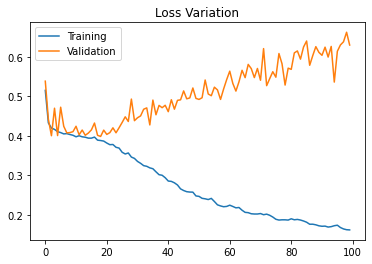

In [23]:
plt.plot(train_loss, label = 'Training')
plt.plot(val_loss, label = 'Validation')
plt.title("Loss Variation")
plt.legend()
plt.show()

It turns out that overfitting had started after epoch 50. Therefore, using the weights saved at that point.

In [24]:
%ls

archive.zip    models/       unet20.pth  unet60.pth  unet.ipynb
CamVid/        __pycache__/  unet30.pth  unet70.pth  UNet.ipynb
Copy.ipynb     unet0.pth     unet40.pth  unet80.pth  utils.py
dataloader.py  unet10.pth    unet50.pth  unet90.pth  VanillaUNet.pth


In [40]:
colors = np.array([[0,0,0], [111,74,0], [81,0,81], [128,64,128], [244, 35, 232]
                   ,[250, 170, 160], [230, 150, 140], [70,70,70], [102,102, 156]
                   , [190, 153, 153], [180, 165, 180], [150, 100, 100]
                   , [150, 120, 90], [153, 153, 153], [250, 170, 30], [220, 220, 0]
                   , [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60]
                   , [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 0, 90]
                   , [0, 0, 110], [0, 80, 100], [0, 0, 230], [119, 11, 32], [0, 0, 142]], dtype = np.uint8)
colors = c2g(colors, grayscale = False)

In [41]:
def testing(image, colors):
  class_pix = np.ones([224,224,3], dtype = np.uint8)
  for index, c in enumerate(colors):
    class_pix[image == index] = c
  return class_pix.reshape((224,224,3))

In [75]:
inputs, labels = next(iter(test_loader))

In [76]:
inputs, labels = inputs.to(device), labels.to(device)

In [77]:
UNET = ResUNet(32)

In [78]:
UNET.load_state_dict(torch.load(os.path.join(os.getcwd(), 'unet20.pth')))

<All keys matched successfully>

In [ ]:
UNET.to(device)

In [80]:
outputs = UNET(inputs)

# Jaccard Index Metric

In [81]:
IOUf = 0
count = 0
for i, data in enumerate(test_loader):
  inputs, labels = data
  inputs = inputs.to(device)
  outputs = UNET(inputs)
  outputs = outputs.cpu()
  outputs = outputs.detach().numpy()
  outputs = outputs.argmax(axis = 1)
  if labels.size() == torch.Size([outputs.shape[0], 1, 224, 224]):
    labels = labels.detach().numpy()
    labels = labels.reshape(outputs.shape[0], 224, 224)
  outputs = outputs.reshape(outputs.shape[0], 224, 224)
  for k in range(outputs.shape[0]):
    o = outputs[k, :, :]
    l = labels[k, :, :]
    IOU = 0
    for c in range(32):
      intersection = 0
      union = 0
      f = c * np.ones((1,224,224))
      i = (o == c) * 1
      j = (l == c) * 1
      inte = 0
      for x in range(224):
        for y in range(224):
          if i[x,y] == j[x,y] and i[x,y] == 1:
            inte = inte + 1
      intersection = intersection + inte
      union = union + ((f == l) * 1).sum() + ((f == o) * 1).sum() - inte
      if union == 0:
        continue
      IOUc = intersection/union
      IOU = IOU + IOUc
    count = count + 1
    IOU = IOU/32
  IOUf = IOUf + IOU

In [82]:
print("IoU: ", IOUf/count)

IoU:  0.04593538746424485


In [95]:
inputs, labels = next(iter(test_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


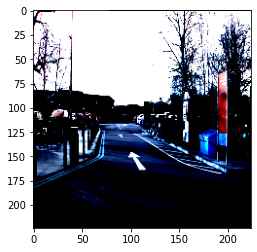

In [96]:
plt.imshow(ndimage.rotate(np.squeeze(inputs.numpy()).transpose(2,1,0), 270), cmap = 'gray')

In [97]:
inputs = inputs.to(device)
outputs = UNET(inputs)

In [98]:
outputs = outputs.cpu()
outputs = outputs.detach().numpy()
outputs = outputs.argmax(axis = 1)

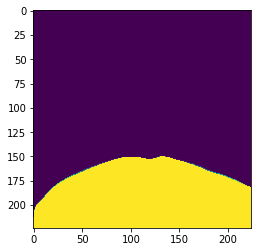

In [99]:
plt.imshow(outputs[0])